In [40]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random


def exponential_weights(v, epsilon, h):
    """
    It gives suggestions to players for probabilities to pick actions given an array of previous payoffs 
    of those actions.

    Args:
      v: an array of payoffs for each action at a given turn
      epsilon: the learning rate
      h: the range of the payoffs

    Returns:
      the optimal probabilities for picking each action at a given turn
    """
    V = np.cumsum(v, axis=1)
    weights = np.power((1 + epsilon), V[:, :-1]/h)
    # because we're referencing the previous column, the first
    # column of ones gets removed so we need to add it back
    weights = np.insert(weights, 0, np.ones(v.shape[0]), axis=1)
    pi = np.divide(weights, np.sum(weights, axis=0))
    return pi


def random_pick(probability_array):
    """
    It generates a random number between 0 and 1, and then returns the index of the first element in the
    probability array that is greater than the random number

    Args:
      probability_array: an array of probabilities, where the sum of all the probabilities is 1.0

    Returns:
      The index of the element in the array that is greater than the random number.
    """
    random_number = np.random.random()
    cumulative_probability = 0.0
    for index, probability in enumerate(probability_array):
        cumulative_probability += probability
        if random_number < cumulative_probability:
            return index
    return len(probability_array) - 1

# part 1


def make_bids_and_qualities(values, rounds):
    """
    It generates bids and qualities for each bidder in each round, and then uses exponential weights to
    generate the bid for the next round

    Args:
      values: the value of each bidder
      rounds: the number of rounds to run the auction for

    Returns:
      bids and qualities
    """
    bidders = len(values)
    qualities = np.random.rand(bidders, rounds)
    bids = np.zeros((bidders, rounds))
    possible_bids = [[i*v/100 for i in range(100)] for v in values]

    bidder_payoffs = [np.zeros((len(possible_bids[0]), rounds))
                      for _ in range(bidders)]
    for round in range(rounds):
        for bidder in range(bidders):
            # generate payoffs for possible bids given, given the other bidders bids
            for bid_i, bid in enumerate(possible_bids[bidder]):
                this_rounds_bids = np.copy(bids[:, round])
                this_rounds_bids[bidder] = bid
                winner = np.argmax(np.multiply(
                    qualities[:, round], this_rounds_bids))

                # assign the payoff as the utility from the bid
                bidder_payoffs[bidder][bid_i][round] = 1 - \
                    bid if winner == bidder else 0
            # run EW on payoffs to get bid for next round
            pi = exponential_weights(bidder_payoffs[bidder], 0.1, 1)

            # randomly pick a bid according to the probabilities generated by exponential weights
            bid = possible_bids[bidder][random_pick(pi[:, round])]
            bids[bidder][round] = bid

    return bids, qualities


def delta_x_and_delta_p(bids, qualities, j):
    """
    It takes in the bids and qualities of all the bidders, and the index of the bidder we're interested
    in, and returns the change in the number of times the bidder wins and the change in the bidder's
    payment as a function of the bidder's bid

    Args:
      bids: a matrix of bids, where each row is a bidder and each column is a round
      qualities: a matrix of size (num_agents, num_rounds)
      j: the bidder we're looking at

    Returns:
      delta_x and delta_p are being returned.
    """
    num_z = 100
    delta_x = np.zeros(num_z)
    delta_p = np.zeros(num_z)
    max_z = 5
    n = len(bids[0])
    for i in range(num_z):
        z = max_z * i / num_z

        for round in range(n):
            this_rounds_bids = np.copy(bids[:, round])
            this_rounds_bids[j] = z
            actual_winner = np.argmax(np.multiply(
                qualities[:, round], bids[:, round]))
            z_winner = np.argmax(np.multiply(
                qualities[:, round], this_rounds_bids))

            delta_x[i] += (1 if actual_winner == j else 0) - \
                (1 if z_winner == j else 0)
            delta_p[i] += (bids[j, round] if actual_winner ==
                           j else 0) - (z if z_winner == j else 0)

        delta_x[i] /= n
        delta_p[i] /= n

    return delta_x, delta_p


def infer_value(bids, qualities, j):
    """
    It takes in the bids and qualities of all the other bidders, and the index of the bidder whose value
    we want to infer. It then calculates the delta_x and delta_p values for that bidder, and then
    iterates through all possible values and epsilons to see which value is rationalizable for the
    lowest possible epsilon

    Args:
      bids: a list of the bids of all the bidders
      qualities: a list of the qualities of all the bids for all the bidders
      j: the bidder we're trying to infer the value for

    Returns:
      The highest rationalizable value for the lowest possible epsilon.
    """
    delta_x, delta_p = delta_x_and_delta_p(bids, qualities, j)
    values = [i/100 for i in range(500)]
    epsilons = [i/100 for i in range(500)]
    rationalizable = [[False for _ in range(500)] for _ in range(500)]
    for ii, e in enumerate(epsilons):
        for jj, v in enumerate(values):
            not_rationalizable_z = [True for r in np.subtract(np.multiply(
                v, delta_x), delta_p) if r < -1 * e]
            rationalizable[ii][jj] = len(not_rationalizable_z) == 0
            # pick the highest rationalizable value for the lowest possible epsilon
            if (~rationalizable[ii][jj] & rationalizable[ii][jj-1]):
                return values[jj-1]

    return 5

In [41]:
N = 100
rounds_arr = [(i+1)*5 for i in range(20)]
error_arr = [0 for i in range(20)]
values = [1, 1.5, 2]
average_inferred_values = [[0, 0, 0] for _ in rounds_arr]
for rounds_i, rounds in enumerate(rounds_arr):
    for _ in range(N):
        bids, qualities = make_bids_and_qualities(values, rounds)
        error = 0
        for j, v in enumerate(values):
            inferred_value = round(infer_value(bids, qualities, j), 3)
            average_inferred_values[rounds_i][j] += inferred_value
            error += (v - inferred_value) ** 2
        error /= len(values)
        error_arr[rounds_i] += error
    error_arr[rounds_i] /= N
    print(f"Error for {rounds} rounds is {error_arr[rounds_i]}")
average_inferred_values = np.divide(average_inferred_values, N)

Error for 5 rounds is 1.592383666666667
Error for 10 rounds is 0.7382699999999999
Error for 15 rounds is 0.4883373333333333
Error for 20 rounds is 0.39909633333333333
Error for 25 rounds is 0.3489366666666666
Error for 30 rounds is 0.2902246666666668
Error for 35 rounds is 0.22975499999999993
Error for 40 rounds is 0.23987899999999981
Error for 45 rounds is 0.25386233333333325
Error for 50 rounds is 0.2525123333333334
Error for 55 rounds is 0.2308496666666666
Error for 60 rounds is 0.25333633333333333
Error for 65 rounds is 0.2468686666666667
Error for 70 rounds is 0.2642886666666666
Error for 75 rounds is 0.23962366666666657
Error for 80 rounds is 0.2651990000000001
Error for 85 rounds is 0.2816626666666667
Error for 90 rounds is 0.27762566666666666
Error for 95 rounds is 0.2852499999999999
Error for 100 rounds is 0.31271233333333326


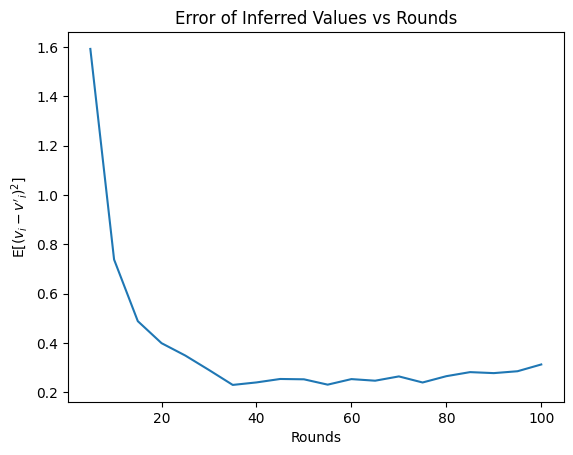

In [42]:
plt.plot(rounds_arr, error_arr)
plt.title("Error of Inferred Values vs Rounds")
plt.xlabel("Rounds")
plt.ylabel("E[$(v_i - v'_i)^2$]")
plt.show()

In [43]:
def get_column(array, column):
  return [row[column] for row in array]

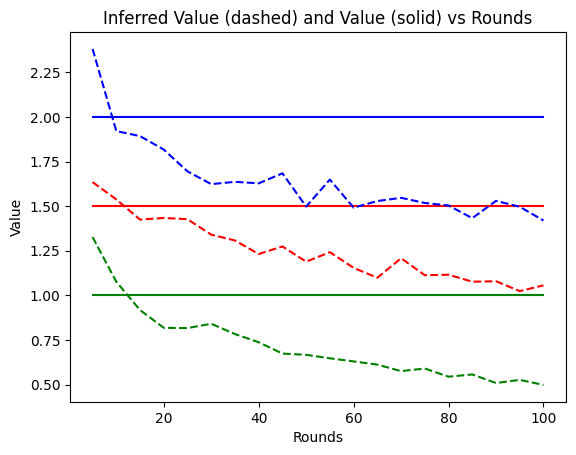

In [44]:
plt.plot(rounds_arr, get_column(average_inferred_values, 0), color="Green", linestyle='--')
plt.plot(rounds_arr, [1 for _ in rounds_arr], color="Green")
plt.plot(rounds_arr, get_column(average_inferred_values, 1), color="Red", linestyle='--')
plt.plot(rounds_arr, [1.5 for _ in rounds_arr], color="Red")
plt.plot(rounds_arr, get_column(average_inferred_values, 2), color="Blue", linestyle='--')
plt.plot(rounds_arr, [2 for _ in rounds_arr], color="Blue")
plt.title("Inferred Value (dashed) and Value (solid) vs Rounds")
plt.xlabel("Rounds")
plt.ylabel("Value")
plt.show()

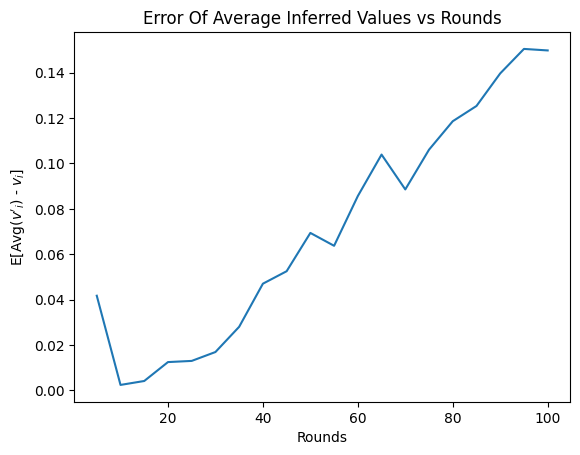

In [49]:
a = np.power(np.subtract(get_column(average_inferred_values, 0), [1 for _ in rounds_arr]), 2)
b = np.power(np.subtract(get_column(average_inferred_values, 1), [1.5 for _ in rounds_arr]), 2)
c = np.power(np.subtract(get_column(average_inferred_values, 2), [2 for _ in rounds_arr]), 2)

plt.plot(rounds_arr, np.divide(np.add(a, b, c),3))
plt.xlabel("Rounds")
plt.ylabel("E[Avg($v'_i$) - $v_i$]")
plt.title("Error Of Average Inferred Values vs Rounds")
plt.show()

This shows that counting error as the difference in each auction's inferred values and actual values is different than counting error as the difference in average inferred value and actual value.
Fewer rounds means betting is more random. For any given auction the inferred values will differ a lot, so error will be high. When we take the average inferred value over 100 trials, it will be closer to the actual value with fewer rounds because the learning algorithm hasn't begun to bid lower over time, which we can observe by simulating bids.

In [ ]:
N = 100
rounds_arr = [(i+1)*5 for i in range(20)]
values = [1, 1.5, 2]
average_bids = [[0 for _ in values] for _ in range(20)]

for i, rounds in enumerate(rounds_arr):
    for _ in range(N):
        bids, qualities = make_bids_and_qualities(values, rounds)
        bids_avg = np.average(bids, axis=1)
        for j, v in enumerate(values):
            average_bids[i][j] += bids_avg[j]
average_bids = np.divide(average_bids, N)

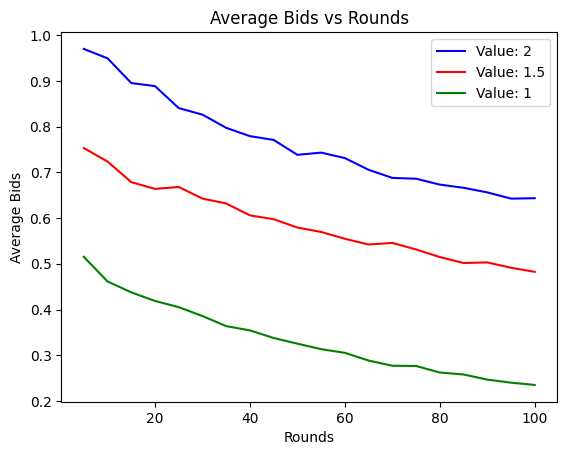

In [52]:
plt.plot(rounds_arr, get_column(average_bids, 2), label="Value: 2", color="Blue")
plt.plot(rounds_arr, get_column(average_bids, 1), label="Value: 1.5", color="Red")
plt.plot(rounds_arr, get_column(average_bids, 0), label="Value: 1", color="Green")
plt.xlabel("Rounds")
plt.ylabel("Average Bids")
plt.title("Average Bids vs Rounds")
plt.legend()
plt.show()